In [1]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from utils.file_utils import open_json, write_json, save_submission
from utils.model_utils import *



/home/ml/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DIR_PATH = "./dataset"
config = open_json(f"{DIR_PATH}/config.json")
features_dict = open_json(f"{DIR_PATH}/features.json")
features = compute_feature_list(config, features_dict)


In [3]:
def train_model(model:Novozymes_Model, optimizer, loss_function, trainloader):
    loss_over_time = []
    # Run the training loop
    for epoch in range(config["num_epochs"]):
        # Set current loss value
        current_loss = 0.0
        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
            # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
            # Zero the gradients
            optimizer.zero_grad()
            # Perform forward pass
            outputs = model(inputs)
            # Compute loss
            loss = loss_function(outputs, targets)
            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()

            current_loss += loss.item()
        loss_over_time.append(current_loss/(i+1))
    return model, loss_over_time


In [4]:
def k_fold_training(df, ksplit, config, features, training_results):
    for k in range(config["k-fold"]):
        train, test = next(ksplit)
        df_train = df[df["protein_index"].isin(train)]
        df_test = df[df["protein_index"].isin(test)]
        dataset_train = prepare_train_data(df_train, config, features)
        X_test, y_test = prepare_test_data(df_test, config, features,
                                           dataset_train.scaler)
        trainloader = torch.utils.data.DataLoader(dataset_train,
                                                  batch_size=config["batch_size"],
                                                  shuffle=False,
                                                  num_workers=config["num_workers"])

        # Initialize a new Novozymes_Model
        model = Novozymes_Model(len(features))

        # Define the loss function and optimizer
        loss_function = nn.L1Loss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        # Train model:
        model, loss_over_time = train_model(
            model, optimizer, loss_function, trainloader)

        # Evaluate this model:
        mse = evaluate_model(X_test, y_test, model)
        # print(f"MSE obtained for k-fold {k}: {mse}")
        results = {"loss_over_time": loss_over_time,
                    "mse": mse}
        training_results.append(results)

    # Process is complete.
    avg_mse = sum(x['mse'] for x in training_results)/config['k-fold']
    print(f"avg mse: {avg_mse}")
    return avg_mse


In [5]:
# loss_list = [x["loss_over_time"] for x in training_results]
# for loss in loss_list:
#     plt.plot(loss)
# plt.show()

In [6]:
# plot the learning curve of the model
# ie. the avg mse when df has 10, 100, 1000 elements
# len(df) = 5k
df = pd.read_csv(f"{DIR_PATH}/{config['dataset_name']}.csv")

num_rows = [100, 1000, 2000, 3000, 4000, len(df)]
avg_mse = [] 

for n in num_rows:
    df_n_rows = df.sample(n)
    # add protein_index to the dataset and get ksplit:
    training_results = []
    df_n_rows, ksplit = split_dataset(df_n_rows, config)
    avg_mse_n_rows = k_fold_training(
        df_n_rows, ksplit, config, features, training_results)
    avg_mse.append(avg_mse_n_rows)



avg mse: 7.299323117107688
avg mse: 5.367676394216533
avg mse: 4.371882718217059


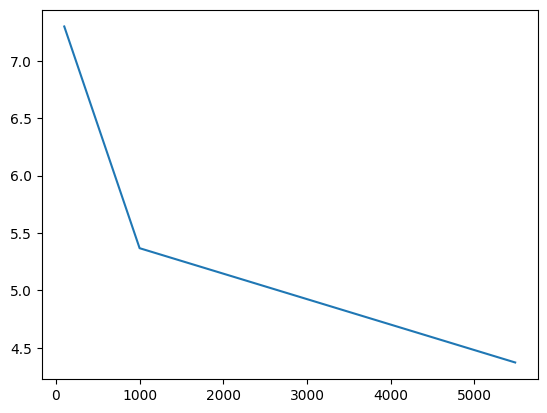

In [9]:
# plot
plt.plot(num_rows, avg_mse)
# print(num_rows, avg_mse)


# Predicting on submission

In [8]:
X_test = torch.from_numpy(X_test).float()
X_test[1, :3]

NameError: name 'X_test' is not defined

In [ ]:
results = net(X_test)
results[:10]

In [ ]:
submission = pd.DataFrame(columns=["seq_id", "tm"])
submission["seq_id"] = df["seq_id"]
submission["tm"] = results.detach().numpy() * -1
submission.head()

In [ ]:
save_submission(submission)